In [1]:
install.packages('dplyr')
install.packages('ggplot2')
install.packages('readr')
install.packages('glmnet')
install.packages('Metrics')
install.packages('MLmetrics')
install.packages('MASS')

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’


Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gdata’, ‘caTools’, ‘gplots’, ‘ROCR’


Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [2]:
require(dplyr)
require(ggplot2)
require(readr)
require(glmnet)
require(Metrics)
require(MLmetrics)
require(MASS)
require(bigrquery)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: readr

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: Metrics

Loading required package: MLmetrics


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: bigrquery



In [3]:
# Provide authentication to connect to BigQuery
bq_auth(use_oob = TRUE)

In [4]:
# Store the GCP project id
projectid = "gcphackathorn"

# Set your query
sql <- "SELECT * FROM dataset_final.final"

# Run query
tb <- bq_project_query(projectid, sql)

# Download query results
df <- bq_table_download(tb)

In [5]:
head(df)

county,state,year,poverty_rate,poverty_male,poverty_female,poverty_white,poverty_black,poverty_native,poverty_asian,⋯,employed,unemployed,killings_total,killings_white,killings_black,killings_hispanic,killings_asian,killings_native,killings_pacific,killings_others
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Nome Census Area,AK,2017,24.9,25.7,24.1,5.7,9.1,31.0,1.4,⋯,3639,724,0,0,0,0,0,0,0,0
Nome Census Area,AK,2014,27.6,27.4,27.9,5.7,3.8,35.4,1.1,⋯,3646,778,0,0,0,0,0,0,0,0
Nome Census Area,AK,2018,23.1,24.0,22.2,2.1,8.3,29.3,1.3,⋯,3664,733,0,0,0,0,0,0,0,0
Nome Census Area,AK,2016,27.0,27.5,26.5,6.9,8.3,33.5,1.6,⋯,3589,758,0,0,0,0,0,0,0,0
Nome Census Area,AK,2015,27.0,27.5,26.5,6.5,10.6,34.5,2.5,⋯,3654,721,0,0,0,0,0,0,0,0
Bethel Census Area,AK,2013,22.8,22.4,23.2,5.2,0.0,25.5,2.2,⋯,6038,1383,0,0,0,0,0,0,0,0


In [6]:
names(df)

[1] "county"                    "state"                    
 [3] "year"                      "poverty_rate"             
 [5] "poverty_male"              "poverty_female"           
 [7] "poverty_white"             "poverty_black"            
 [9] "poverty_native"            "poverty_asian"            
[11] "poverty_pacific"           "poverty_others"           
[13] "poverty_hispanic"          "poverty_below_high_school"
[15] "poverty_high_school_grad"  "poverty_college"          
[17] "poverty_bachelor"          "poverty_employed"         
[19] "poverty_unemployed"        "population"               
[21] "male"                      "female"                   
[23] "white"                     "black"                    
[25] "native"                    "asian"                    
[27] "pacific"                   "others"                   
[29] "hispanic"                  "below_high_school"        
[31] "high_school_grad"          "college"                  
[33] "bachelor"                  "employed"                 
[35] "unemployed"                "killings_total"           
[37] "killings_white"            "killings_black"           
[39] "killings_hispanic"         "killings_asian"           
[41] "killings_native"           "killings_pacific"         
[43] "killings_others"

In [7]:
Train <- df %>% 
  transmute(killings_hispanic,
            year,
            state,
            poverty_rate,
            poverty_male,
            poverty_hispanic,
            poverty_below_high_school,
            male_perc = round(male/population*100,2),
            hispanic_perc = round(hispanic/population*100,2),
            below_high_school_perc = round(below_high_school/population*100,2),
            unemployment_rate = round(unemployed/population*100,2),
            killings_total
          ) %>%
    mutate(state = as.factor(state)) %>%
         na.omit()   # remove rows with missings

In [8]:
names(Train)

[1] "killings_hispanic"         "year"                     
 [3] "state"                     "poverty_rate"             
 [5] "poverty_male"              "poverty_hispanic"         
 [7] "poverty_below_high_school" "male_perc"                
 [9] "hispanic_perc"             "below_high_school_perc"   
[11] "unemployment_rate"         "killings_total"

In [9]:
head(Train) %>% as.data.frame()

killings_hispanic,year,state,poverty_rate,poverty_male,poverty_hispanic,poverty_below_high_school,male_perc,hispanic_perc,below_high_school_perc,unemployment_rate,killings_total
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,2017,AK,24.9,25.7,4.8,38.4,52.51,2.40,8.30,7.58,0
0,2014,AK,27.6,27.4,2.1,39.8,52.83,1.50,8.43,8.16,0
0,2018,AK,23.1,24.0,3.7,36.5,51.89,2.53,8.45,7.64,0
0,2016,AK,27.0,27.5,3.3,40.5,53.27,2.19,8.42,7.90,0
0,2015,AK,27.0,27.5,3.1,40.3,53.05,1.99,8.62,7.51,0
0,2013,AK,22.8,22.4,16.0,22.6,51.74,1.29,10.59,8.13,0


In [10]:
#Creating objects for regression
y = as.numeric(Train$killings_hispanic)          # our y variable
d = Train$poverty_hispanic                    # our treatment variable

Train =  Train %>% dplyr::select(-killings_hispanic, -poverty_hispanic)    # remove y and d from Train 
X = model.matrix(d ~ ., Train) # select all variables and remove Intercept 

In [11]:
colnames(X)

[1] "(Intercept)"               "year"                     
 [3] "stateAK"                   "stateAL"                  
 [5] "stateAR"                   "stateAZ"                  
 [7] "stateCA"                   "stateCO"                  
 [9] "stateCT"                   "stateDE"                  
[11] "stateFL"                   "stateGA"                  
[13] "stateHI"                   "stateIA"                  
[15] "stateID"                   "stateIL"                  
[17] "stateIN"                   "stateKS"                  
[19] "stateKY"                   "stateLA"                  
[21] "stateMA"                   "stateMD"                  
[23] "stateME"                   "stateMI"                  
[25] "stateMN"                   "stateMO"                  
[27] "stateMS"                   "stateMT"                  
[29] "stateNC"                   "stateND"                  
[31] "stateNE"                   "stateNH"                  
[33] "stateNJ"                   "stateNM"                  
[35] "stateNV"                   "stateNY"                  
[37] "stateOH"                   "stateOK"                  
[39] "stateOR"                   "statePA"                  
[41] "statePR"                   "stateRI"                  
[43] "stateSC"                   "stateSD"                  
[45] "stateTN"                   "stateTX"                  
[47] "stateUT"                   "stateVA"                  
[49] "stateVT"                   "stateWA"                  
[51] "stateWI"                   "stateWV"                  
[53] "stateWY"                   "poverty_rate"             
[55] "poverty_male"              "poverty_below_high_school"
[57] "male_perc"                 "hispanic_perc"            
[59] "below_high_school_perc"    "unemployment_rate"        
[61] "killings_total"

# Causal Lasso

## 1st Stage

In [12]:
install.packages('doParallel')

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [13]:
# Setting lambda interval
lamb_range = 10 ^ seq(1, -7, length= 100) 

Train2 = as.matrix(Train)
### Runs CV - Lasso

library(doParallel)
registerDoParallel(5)
set.seed(9547)
cv_lasso= cv.glmnet(y = d, 
                    x = X, 
                    alpha = 1, 
                    nfolds = 5,
                    lambda = lamb_range,
                    standardize=TRUE,
                    parallel=TRUE)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



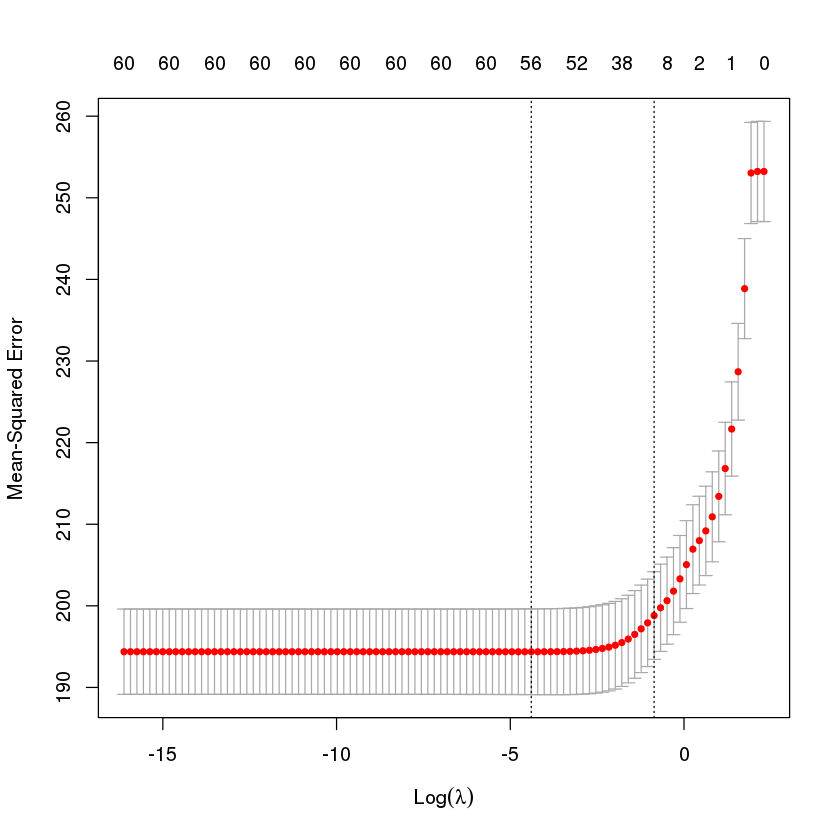

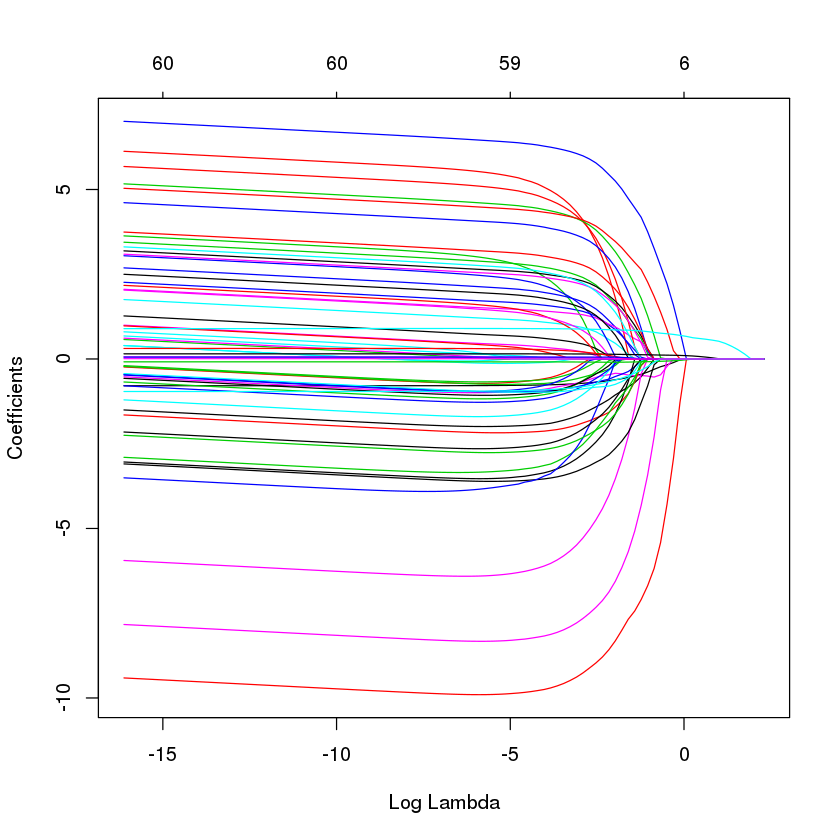

In [14]:
# Plots the MSE errors
plot(cv_lasso)

# Plots the Paths
plot(cv_lasso$glmnet.fit, xvar="lambda")

[1] 198.8118


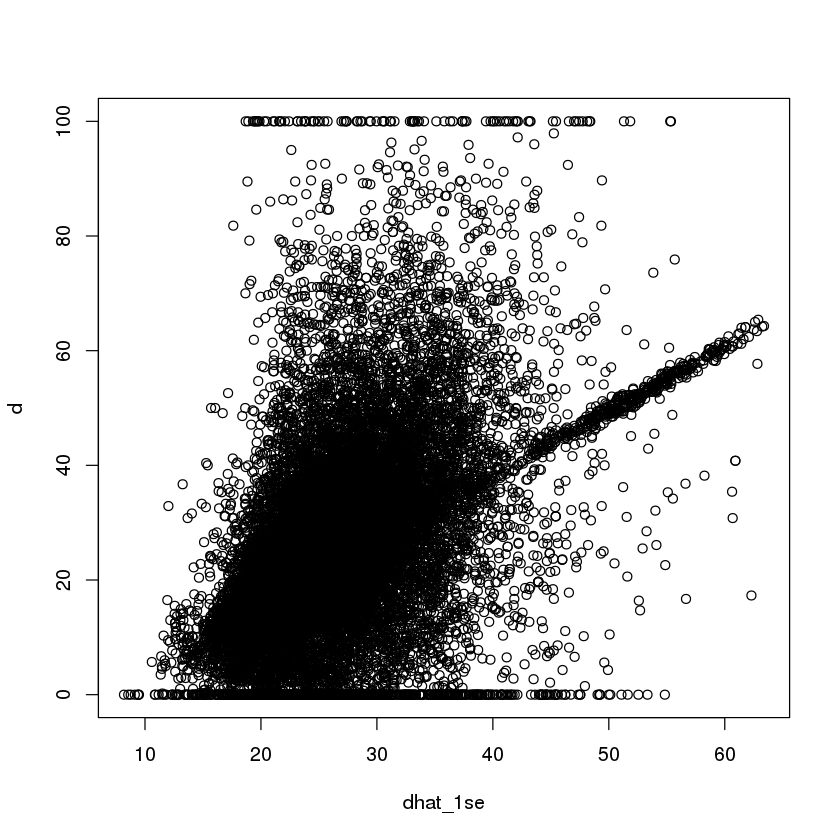

In [15]:
# Estimating D Hat

### Retrieves the lambdas
sd1_lambda = cv_lasso$lambda.1se

# Mean squared errors from best lambdas
print(cv_lasso$cvm[which(cv_lasso$lambda == cv_lasso$lambda.1se)])

# In-sample dhats
dhat_1se = predict(object = cv_lasso, s = "lambda.1se", newx = X)
colnames(dhat_1se) <- "dhat"

# Plot d against dhat
plot(dhat_1se, d)

## 2nd Stage

In [16]:
X2 = cbind(dhat=dhat_1se, treatment = d, X)

In [17]:
# Leave dhat unpenalized
penalty_list = rep(1,ncol(X2))
penalty_list[1] = 0

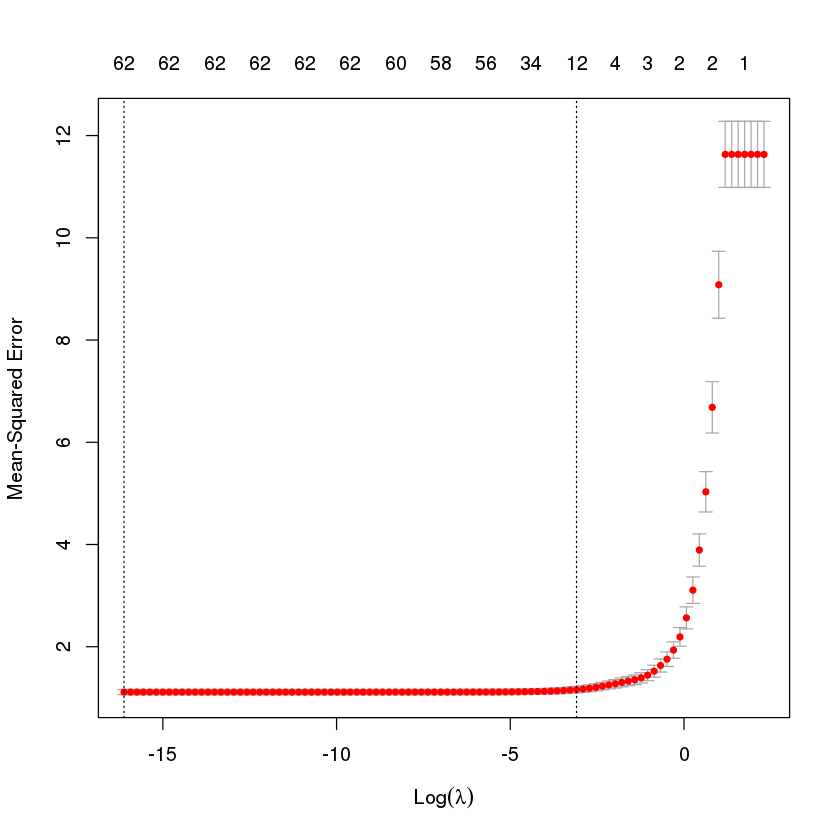

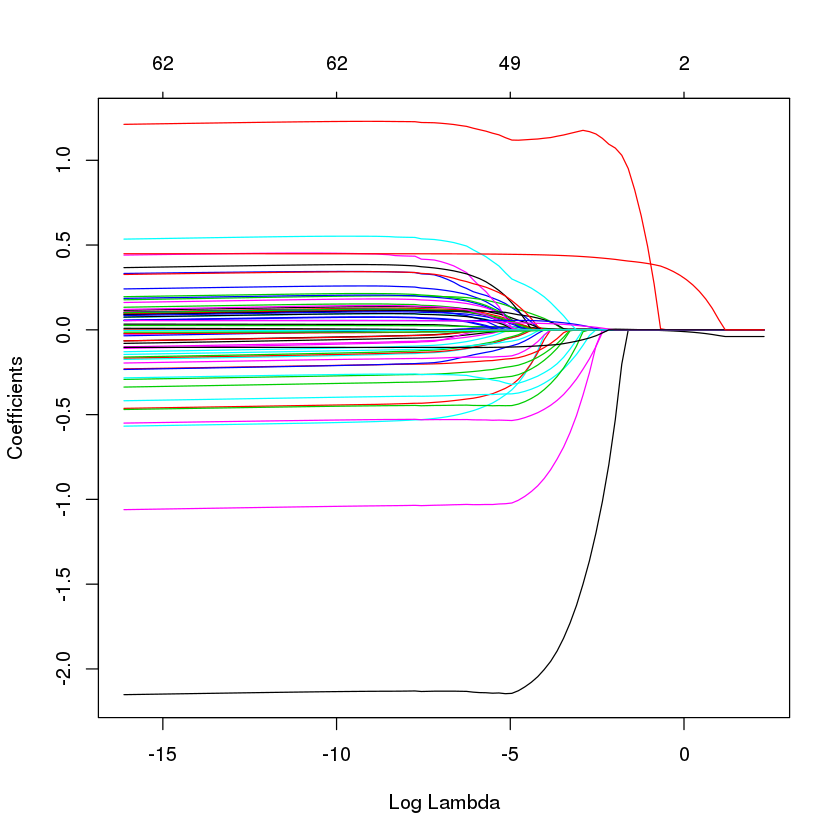

In [18]:
### Run Lasso with dhat unpenalized
set.seed(17)

cv_lasso_final = cv.glmnet(y = y, 
                    x = X2, 
                    alpha = 1, 
                    nfolds = 5,
                    penalty.factor = penalty_list,
                    lambda = lamb_range,
                    standardize=TRUE,
                    parallel=TRUE)

# Plots the MSE errors
plot(cv_lasso_final)

# Plots the Paths
plot(cv_lasso_final$glmnet.fit, xvar="lambda")

In [19]:
cv_lasso_final


Call:  cv.glmnet(x = X2, y = y, lambda = lamb_range, nfolds = 5, parallel = TRUE,      alpha = 1, penalty.factor = penalty_list, standardize = TRUE) 

Measure: Mean-Squared Error 

     Lambda Measure      SE Nonzero
min 0.00000   1.113 0.05036      62
1se 0.04535   1.160 0.06330      12

In [20]:
# Number of variables selected by Lasso
print("Total variables left:")
print(sum(coef(cv_lasso_final, select="1se") != 0))    # 43 variables survived

# Optimal lambda: 
lambda_final = cv_lasso_final$lambda.1se # 0.0053
print("final lambda:")
print(lambda_final)

#### !!! Coefficient of Degree variable after controlling for unpenalized dhat. 
impact = coef(cv_lasso_final, select = "lambda.min")["treatment",]
print('impact:')
impact

[1] "Total variables left:"
[1] 13
[1] "final lambda:"
[1] 0.04534879
[1] "impact:"


[1] 0

In [21]:
# Mean The mean cross-validated error from best lambda
cv_lasso_final$cvm[which(cv_lasso_final$lambda == cv_lasso_final$lambda.1se)]

### AIC
fit2 <- glmnet(y = y,
               x = X2,
               alpha = 1,
               penalty.factor = penalty_list,
               lambda = cv_lasso_final$lambda.1se,
               standardize=TRUE)

tLL2 <- fit2$nulldev - deviance(fit2)
k2 <- fit2$df
n2 <- fit2$nobs
AICc2 <- -tLL2+2*k2+2*k2*(k2+1)/(n2-k2-1)
AICc2

fit2$dev.ratio  # considered R squared

[1] 1.160383

[1] -237581

[1] 0.9014922

## Bootstrap

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
 2.5% 97.5% 
    0     0 


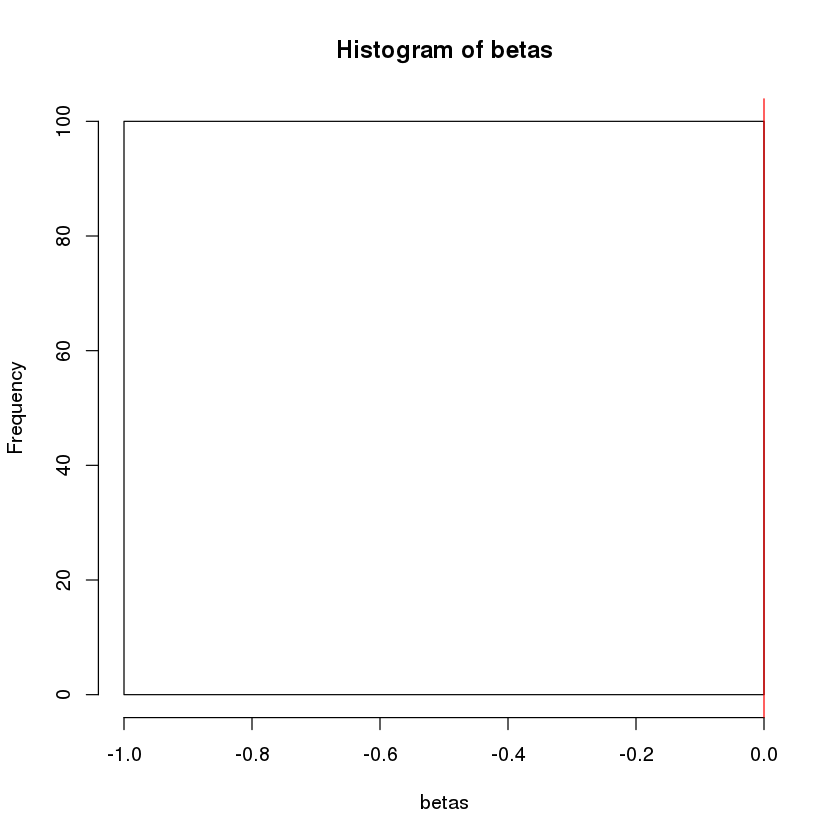

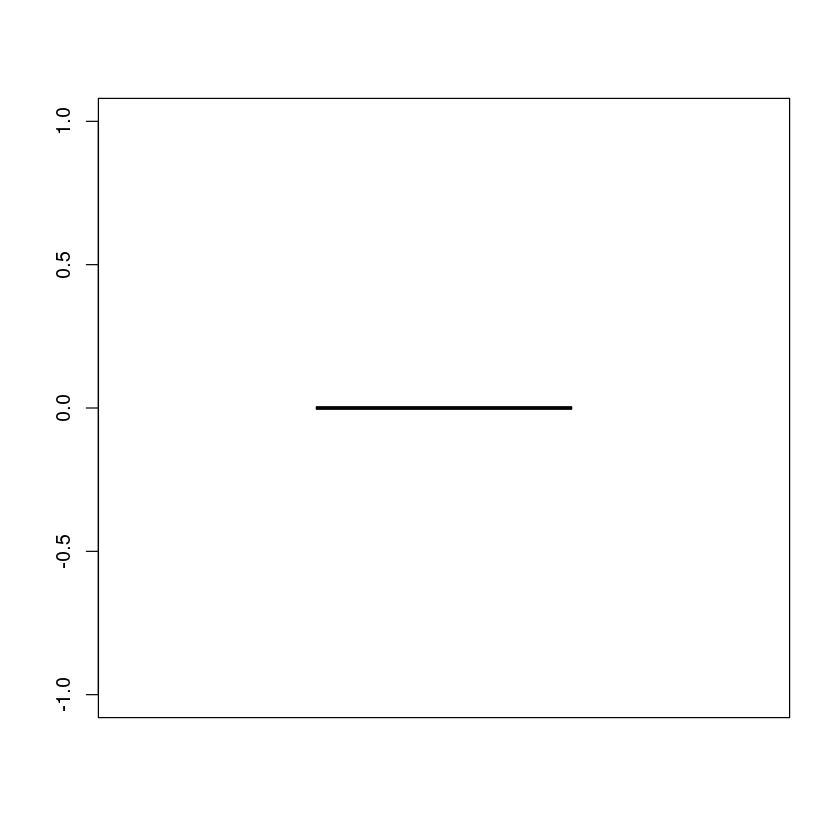

In [22]:
n <- nrow(X2)
betas <- c()

for(ind in 1:100){
  print(ind)
  sam_boot <- sample(1:n, n, replace=T)
  lfit = glmnet(y = y[sam_boot], 
                x = X2[sam_boot,], 
                alpha = 1, 
                penalty.factor = penalty_list,
                lambda = lambda_final,  # min lambda from 3rd question
                standardize=TRUE)
  degree_coef = coef(lfit)["treatment",]
  betas[ind] <- as.numeric(degree_coef)
  
}

betas <- sort(betas)

print(quantile(betas, c(.025, 0.975)))  # confidence interval

# Print histogram of betas (booststrap)
hist(betas, nclass = 20)
abline(v=impact, col=2)

boxplot(betas)